### Multi Query Prompt Approach

- Explanation: The Multi-Query approach involves sending multiple variations of a query to the search system and then aggregating the results. This can enhance recall and precision by covering different possible interpretations of the query.

- Use Cases:

    - Search Engines: Enhances the relevance of search results by covering different ways users might phrase a query.
    - Question Answering Systems: Improves accuracy by considering multiple forms of the same question, ensuring a more comprehensive answer.
    - E-commerce: Enhances product search by considering different variations of product names or descriptions, improving user experience.

Docs: https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever

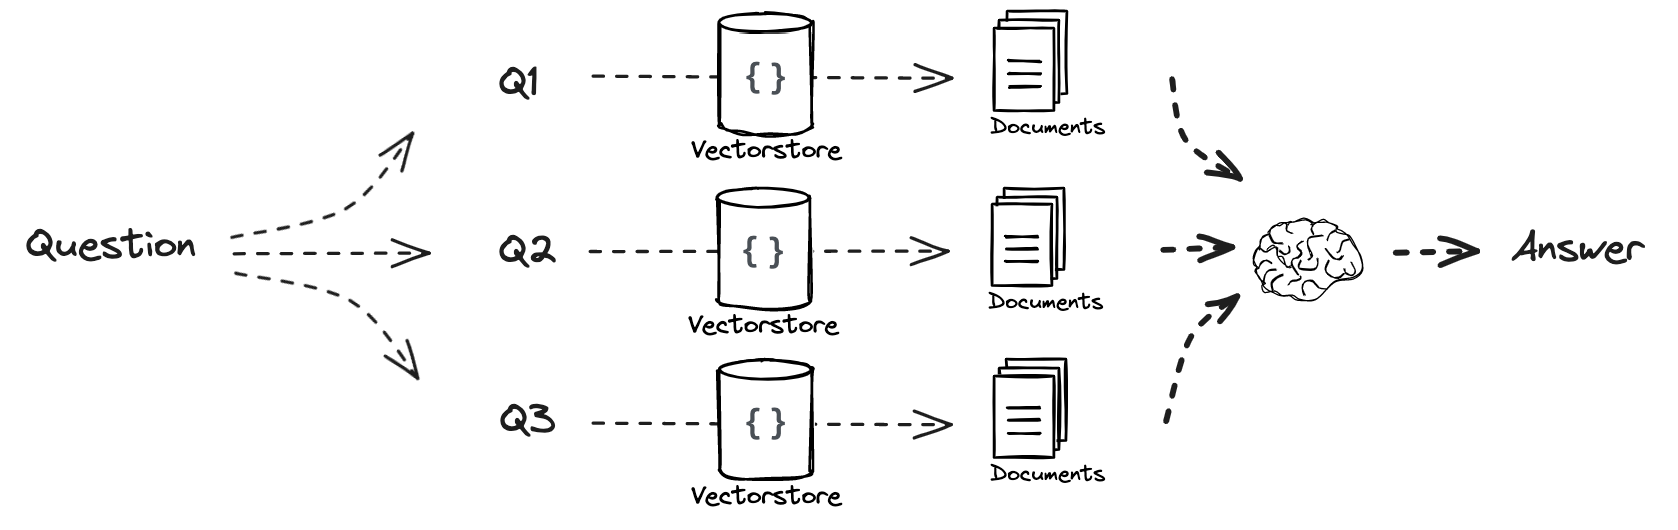

In [ ]:

from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)


from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})



### RAG-Fusion Approach

- Explanation: RAG Fusion combines retrieved documents with generative models to provide more accurate and contextually relevant answers. It uses retrieved documents as context to generate responses, leveraging both retrieval and generation strengths.

- Use Cases:

    - Customer Support: Provides precise and contextually relevant responses by combining retrieved knowledge with generative capabilities.
    - Knowledge Management: Enhances responses by integrating external knowledge sources, ensuring comprehensive and updated information.
    - Content Creation: Assists in generating well-informed content by incorporating relevant data from multiple sources.

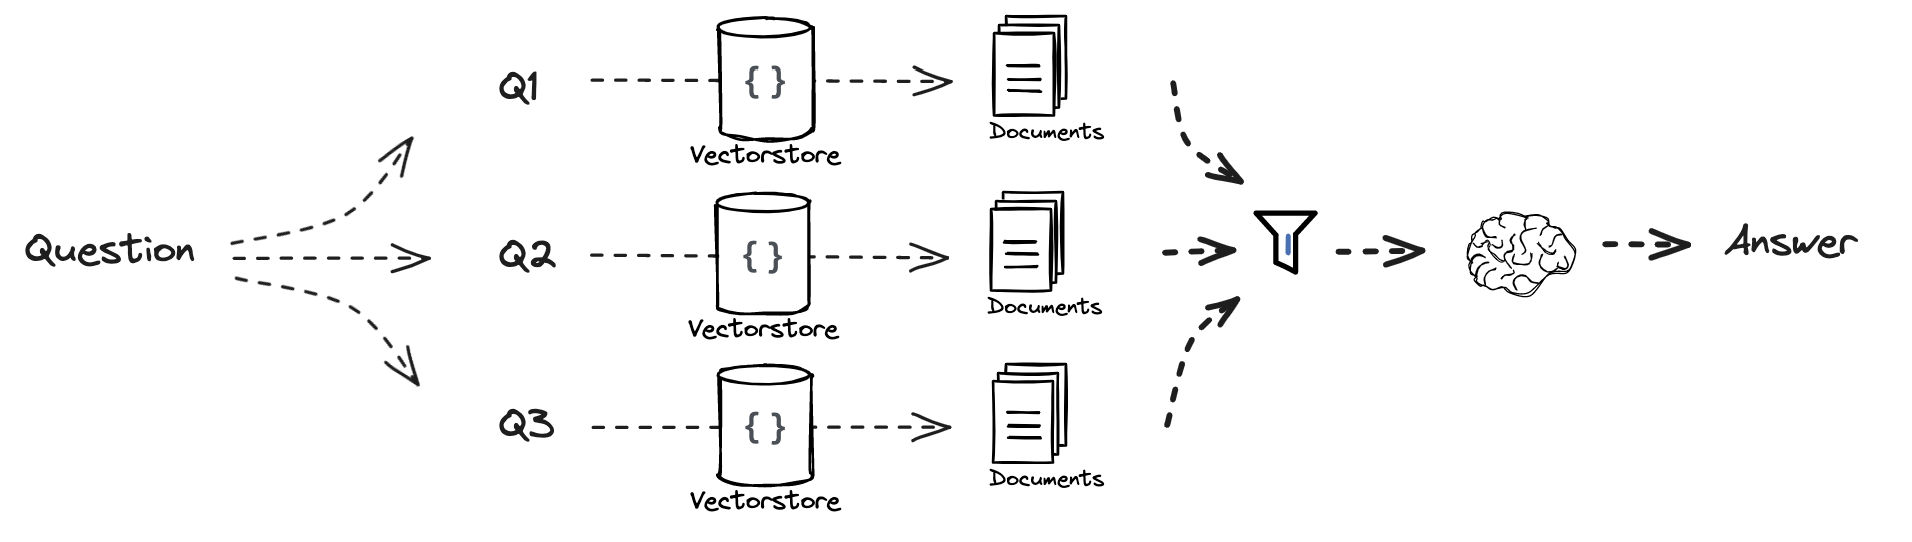

In [ ]:

from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)


from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

### Decomposition Approach to Query Translation


- Explanation: The Decomposition approach breaks down complex queries into simpler sub-queries, processes them individually, and then combines the results. This makes it easier to handle complex information needs.

- Use Cases:

    - Complex Query Handling: Efficiently processes multi-faceted queries by breaking them into manageable parts, ensuring accurate and relevant responses.
    - Scientific Research: Assists in literature searches by decomposing complex research questions into simpler, targeted queries.
    - Business Intelligence: Improves data analysis by decomposing intricate queries into simpler ones, facilitating more precise and actionable insights.

!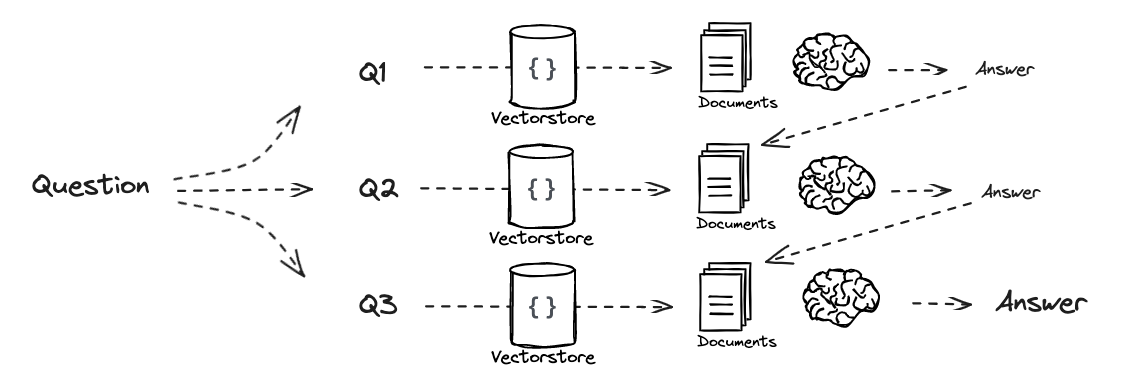

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})